In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import codecs
from scipy.stats import fisher_exact
from datetime import timedelta

In [2]:
def mergeodds(row,fraud_total,normal_total):
    table = [[row.iloc[0],fraud_total - row.iloc[0]],[row.iloc[1],normal_total - row.iloc[1]]]
    return fisher_exact(table)

def mergeodds_OLD(row):
    if not np.isnan(row.iloc[0]):
        odd1 = row.iloc[0]/(1-row.iloc[0])
    else:
        odd1 = 1e-63/(1 - 1e-63)
    if not np.isnan(row.iloc[1]):
        odd2 = row.iloc[1]/(1-row.iloc[1])
    else:
        odd2 = 1e-63/(1 - 1e-63)
    return odd1/odd2

def getmerge_OLD(fraud_freq,normal_freq, join='inner'):
    merge = pd.concat([fraud_freq,normal_freq], axis=1, join = join)
    merge['OR'] = merge.apply(lambda x: mergeodds_OLD(x),axis=1) 
    return merge

def displayOR_OLD(merge, highor=2, lowor=0.5):
    display(merge[merge['OR'] > highor])
    display(merge[merge['OR'] < lowor])

def getmerge(fraud,normal, join='inner'):
    merge = pd.concat([fraud.value_counts(),normal.value_counts()], axis=1, join = join)
    merge['不正割合'] = merge.iloc[:,0]/fraud_total
    merge['正常割合'] = merge.iloc[:,1]/normal_total
    merge['OR'] = merge.apply(lambda x: mergeodds(x,fraud_total,normal_total)[0],axis=1) 
    merge['p value'] = merge.apply(lambda x: mergeodds(x,fraud_total,normal_total)[1],axis=1) 
    return merge

def displayOR(merge, highor=2, lowor=0.5, pTreshold = 0.05):
    display(merge[(merge['OR'] > highor) & (merge['p value'] < pTreshold)])
    display(merge[(merge['OR'] < lowor) & (merge['p value'] < pTreshold)])
    
def colFreq(fraud_dataset,normal_dataset,column):
    fraud_f = np.divide(fraud_dataset[column].value_counts(),fraud_dataset[column].count())
    normal_f = np.divide(normal_dataset[column].value_counts(),normal_dataset[column].count())
    return fraud_f,normal_f
    
def plotDistr(fraud_freq,normal_freq, treshold_f=0.001,treshold_n=0.001):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharey=True)

    fraud_freq[fraud_freq>treshold_f].sort_index().plot(ax=axes[0],kind='bar',title='fraud')
    normal_freq[normal_freq>treshold_n].sort_index().plot(ax=axes[1],kind='bar',title='normal')

def formatTime(fraud_dataset,normal_dataset, columns):
    
    for i in columns:
        fraud_df[i] = pd.to_datetime(fraud_df[i])
        normal_df[i] = pd.to_datetime(normal_df[i])
        
        weekdayTitle = i[:-2] + '曜日'
        hourTitle = i[:-2] + '時間'
        
        fraud_df[weekdayTitle] = fraud_df[i].dt.dayofweek
        normal_df[weekdayTitle] = normal_df[i].dt.dayofweek
        fraud_df[hourTitle] = fraud_df[i].dt.hour
        normal_df[hourTitle] = normal_df[i].dt.hour

def generateReport(fraud_dataset,normal_dataset,columns):
    for i in columns:
        fraud_ipc, normal_ipc = plotDistr(colFreq(fraud_dataset,normal_dataset,i))
        displayOR(getmerge(fraud_df[i],normal_df[i]))

In [3]:
fraud_df = pd.read_csv('data/Jalan_Ext_Tran_Chargeback_JIR_JALAN_20180625152817.csv', encoding="SHIFT-JIS")
with codecs.open("data/Jalan_Ext_Tran_Not_Chargeback_JIR_JALAN_20180625161404.csv", "r", "Shift-JIS", "ignore") as file:
    normal_df = pd.read_table(file, delimiter=",")

In [4]:
fraud_total = len(fraud_df)
normal_total = len(normal_df)

In [5]:
headers = list(fraud_df.columns.values)

In [6]:
headers

['トランザクションID',
 'RESOLUTION1_NAME',
 'MODIFIED',
 'NULLは新規分0605森田さん追加CB情報',
 '会員ID',
 'クレジットカード名義',
 'トランザクション 合計 金額',
 'トランザクション 日時',
 '会員登録日時',
 'Billing Emailアドレス',
 'Billing 住所',
 'Billing フルネーム',
 'Billing POST_CODE',
 'Billing POST_CODE緯度',
 'Billing POST_CODE経度',
 '会員 Emailアドレス',
 '会員 フルネーム',
 'InAuthデバイスID',
 'InAuth デバイス 実IPアドレス',
 'InAuth デバイス 実IP 国名',
 'InAuth ブラウザ ナビゲータ 言語',
 'InAuth ユーザエージェント OS',
 'トランザクションスコア',
 'InAuth デバイス位置情報 国コード\u3000',
 'InAuth デバイス位置情報 都市',
 'InAuth デバイス位置情報 地域',
 'InAuth デバイス位置緯度',
 'InAuth デバイス位置経度',
 'クレンズ済課金電話番号',
 'クレンズ済課金電話番号81',
 'IPアドレス',
 'InAuthブラウザクライアント情報言語',
 'チェックイン日時',
 'チェックアウト日時',
 '宿泊ID',
 '宿泊先名',
 '宿泊代表者フルネーム',
 'トリップしたルール']

InAuth デバイス 実IP 国名  InAuth デバイス 実IP 国名      不正割合      正常割合  \
japan                    1602              439106  0.903044  0.740072   
china                      48                1001  0.027057  0.001687   
australia                  24                 269  0.013529  0.000453   
germany                     2                 102  0.001127  0.000172   
france                      2                  85  0.001127  0.000143   

                  OR       p value  
japan       3.271251  1.853017e-66  
china      16.456165  4.823786e-40  
australia  30.235666  9.516621e-27  
germany     6.564279  3.894138e-02  
france      7.877360  2.811156e-02

InAuth デバイス 実IP 国名  InAuth デバイス 実IP 国名      不正割合      正常割合  \
hong kong                   1                1981  0.000564  0.003339   

                 OR   p value  
hong kong  0.168364  0.036291

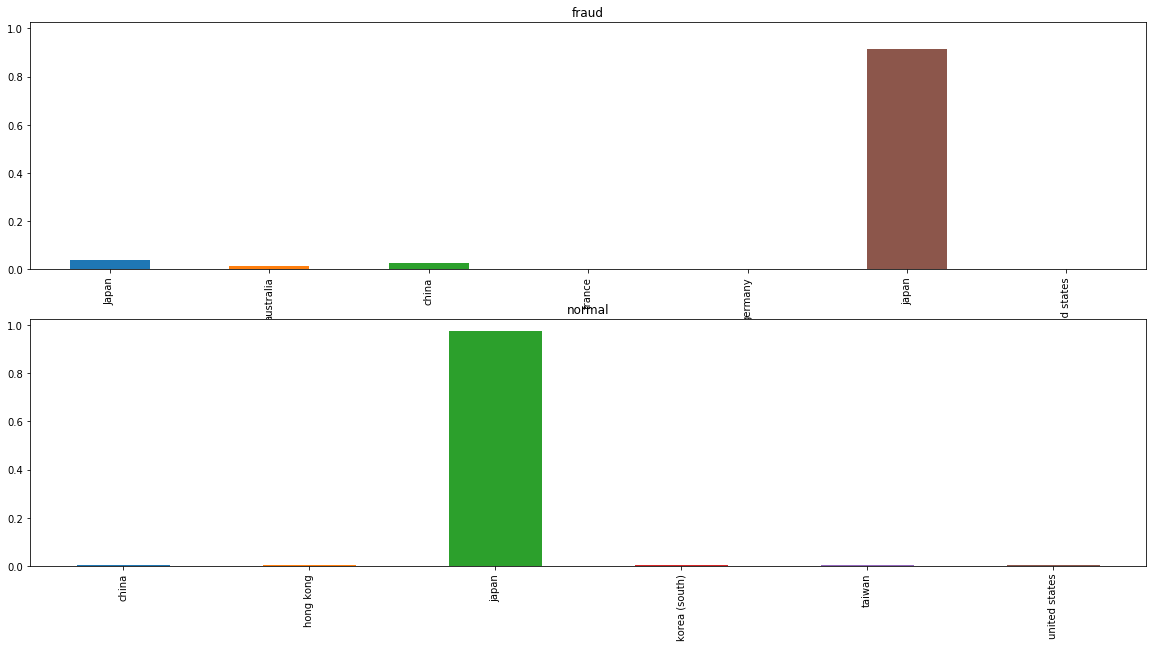

In [7]:
fraud_ipc, normal_ipc = colFreq(fraud_df,normal_df,'InAuth デバイス 実IP 国名')
plotDistr(fraud_ipc,normal_ipc)
displayOR(getmerge(fraud_df['InAuth デバイス 実IP 国名'],normal_df['InAuth デバイス 実IP 国名']))

InAuth ブラウザ ナビゲータ 言語  InAuth ブラウザ ナビゲータ 言語      不正割合      正常割合  \
ja                     1103                144386  0.621759  0.243349   
zh-CN                   580                  2071  0.326945  0.003490   

               OR        p value  
ja       5.111156  9.565957e-249  
zh-CN  138.682160   0.000000e+00

InAuth ブラウザ ナビゲータ 言語  InAuth ブラウザ ナビゲータ 言語      不正割合      正常割合  \
ja-JP                    61                275820  0.034386  0.464869   
en-US                     4                  5877  0.002255  0.009905   
ja-jp                     4                 15052  0.002255  0.025369   

             OR       p value  
ja-JP  0.040992  0.000000e+00  
en-US  0.225893  2.509171e-04  
ja-jp  0.086822  8.143557e-15

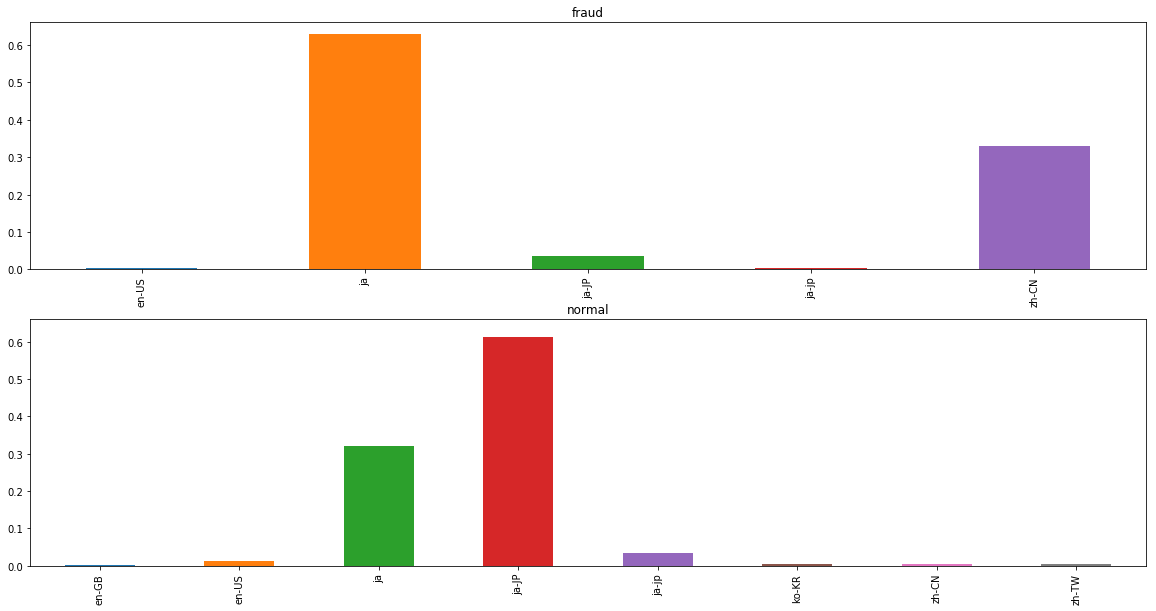

In [8]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'InAuth ブラウザ ナビゲータ 言語')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['InAuth ブラウザ ナビゲータ 言語'],normal_df['InAuth ブラウザ ナビゲータ 言語']))

InAuthブラウザクライアント情報言語  InAuthブラウザクライアント情報言語      不正割合      正常割合  \
ja                     1006                111415  0.567080  0.187779   
zh-CN                   473                  1762  0.266629  0.002970   

               OR        p value  
ja       5.665818  2.760903e-274  
zh-CN  122.062393   0.000000e+00

InAuthブラウザクライアント情報言語  InAuthブラウザクライアント情報言語      不正割合      正常割合  \
ja-JP                    56                240213  0.031567  0.404856   
en-US                     4                  4831  0.002255  0.008142   
ja-jp                     4                 15044  0.002255  0.025355   

             OR        p value  
ja-JP  0.047917  2.686836e-302  
en-US  0.275293   3.107484e-03  
ja-jp  0.086869   8.069718e-15

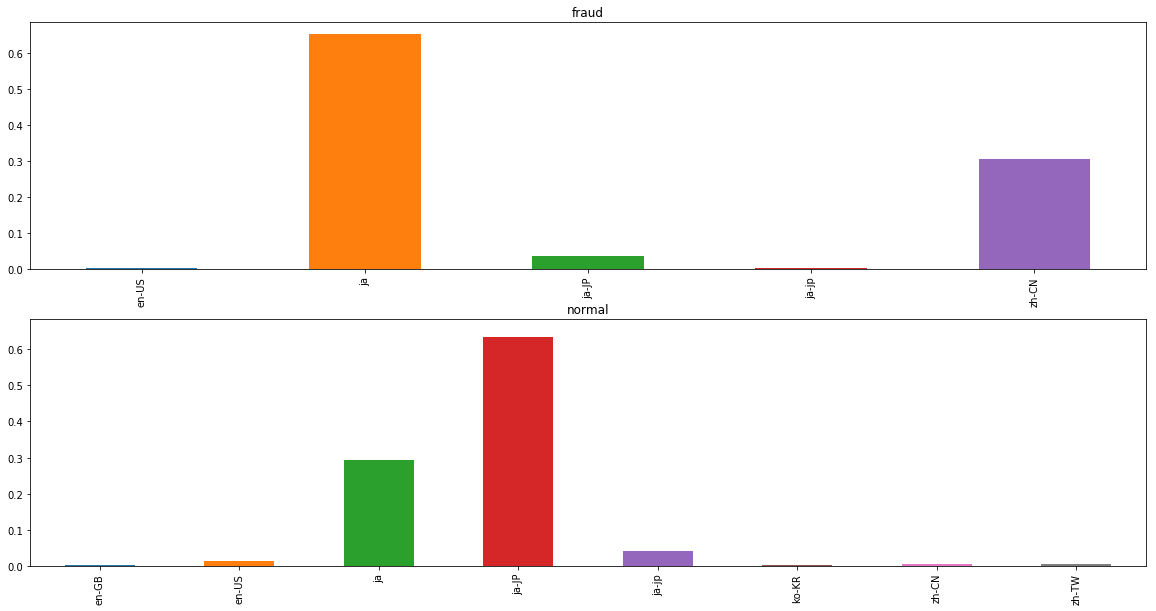

In [9]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'InAuthブラウザクライアント情報言語')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['InAuthブラウザクライアント情報言語'],normal_df['InAuthブラウザクライアント情報言語']))

In [10]:
def compBrowserLanguage(row):
    if row['InAuth ブラウザ ナビゲータ 言語'] == row['InAuthブラウザクライアント情報言語']:
        return True
    else :
        return False


In [11]:
fraud_df['lang_comp'] = fraud_df.apply(lambda x: compBrowserLanguage(x),axis=1)
normal_df['lang_comp'] = normal_df.apply(lambda x: compBrowserLanguage(x),axis=1)

lang_comp  lang_comp      不正割合      正常割合        OR        p value
True       1543     378618  0.869786  0.638125  3.787974  9.792718e-107

lang_comp  lang_comp      不正割合      正常割合        OR        p value
False        231     214711  0.130214  0.361875  0.263993  9.792718e-107

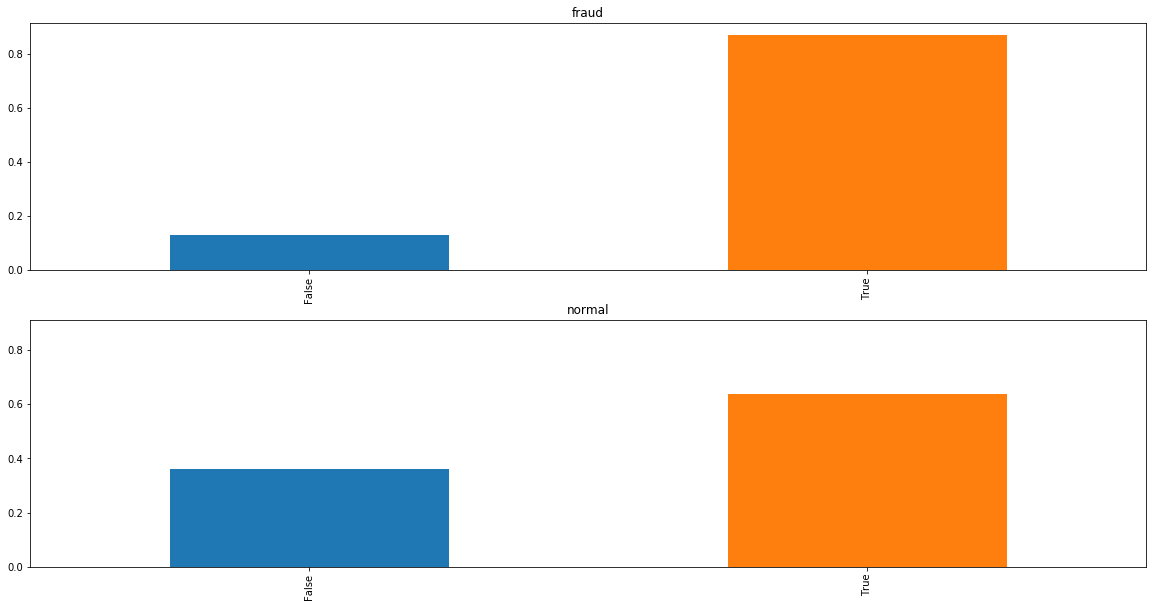

In [12]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'lang_comp')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['lang_comp'],normal_df['lang_comp']))

InAuth デバイス位置情報 国コード　  InAuth デバイス位置情報 国コード　      不正割合      正常割合  \
jp                   1602                 439143  0.903044  0.740134   
cn                     48                    890  0.027057  0.001500   
au                     24                    268  0.013529  0.000452   
de                      2                    104  0.001127  0.000175   
fr                      2                     86  0.001127  0.000145   

           OR       p value  
jp   3.270190  1.870548e-66  
cn  18.512031  2.704104e-42  
au  30.348537  8.761818e-27  
de   6.438021  4.030460e-02  
fr   7.785750  2.870944e-02

InAuth デバイス位置情報 国コード　  InAuth デバイス位置情報 国コード　      不正割合      正常割合  \
hk                      1                   2006  0.000564  0.003381   

          OR   p value  
hk  0.166259  0.036726

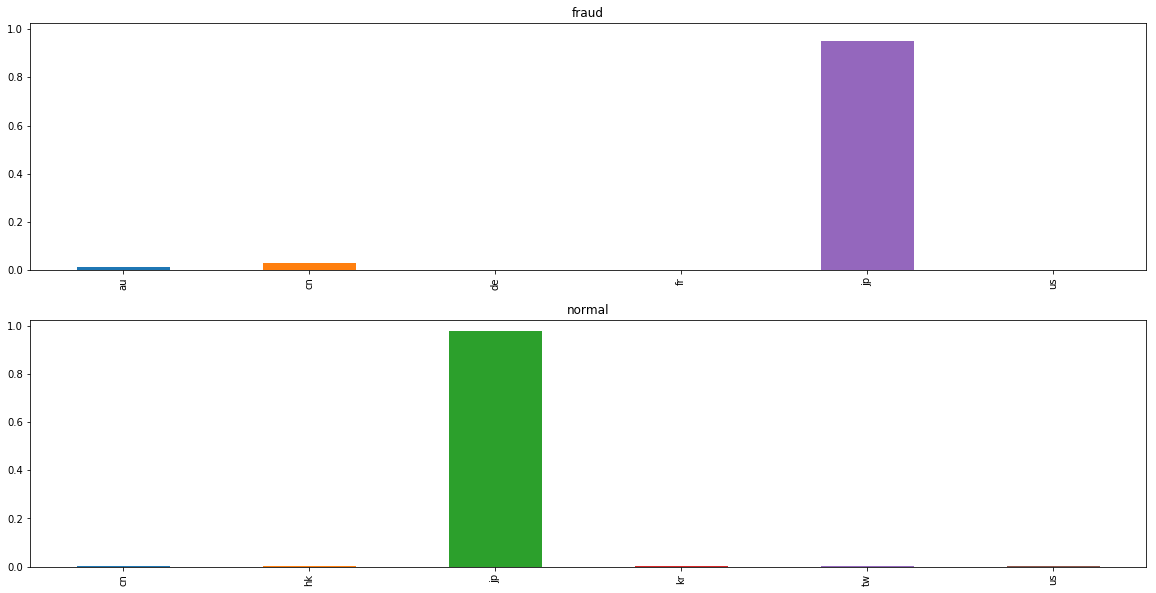

In [13]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'InAuth デバイス位置情報 国コード\u3000')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['InAuth デバイス位置情報 国コード\u3000'],normal_df['InAuth デバイス位置情報 国コード\u3000']))

InAuth ユーザエージェント OS  InAuth ユーザエージェント OS      不正割合      正常割合  \
Windows 8.1                 1193                 7268  0.672492  0.012250   
Windows 7                    429                36736  0.241826  0.061915   

                     OR        p value  
Windows 8.1  165.574028   0.000000e+00  
Windows 7      4.832600  4.169208e-131

InAuth ユーザエージェント OS  InAuth ユーザエージェント OS      不正割合      正常割合  \
iOS                       52               183418  0.029312  0.309134   
Windows                   32                98543  0.018038  0.166085   
Android                   28                90170  0.015784  0.151973   
OS X                       5                22346  0.002818  0.037662   

               OR        p value  
iOS      0.067487  2.046769e-202  
Windows  0.092235   3.067663e-94  
Android  0.089486   7.371024e-87  
OS X     0.072221   8.158640e-23

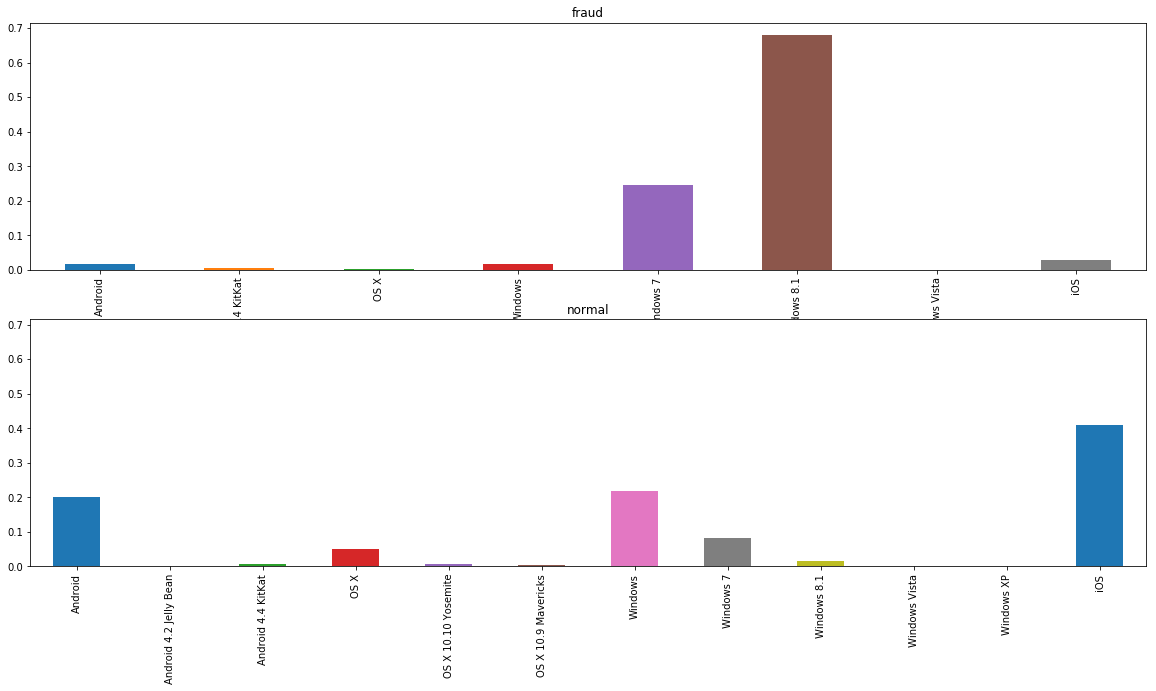

In [14]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'InAuth ユーザエージェント OS')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['InAuth ユーザエージェント OS'],normal_df['InAuth ユーザエージェント OS']))

In [15]:
fraud_df['Billing Emailアドレス'] = fraud_df['Billing Emailアドレス'].fillna('')
normal_df['Billing Emailアドレス'] = normal_df['Billing Emailアドレス'].fillna('')

fraud_df['メール長さ'] = fraud_df['Billing Emailアドレス'].str.len()
normal_df['メール長さ'] = normal_df['Billing Emailアドレス'].str.len()

fraud_df['メール数字'] = fraud_df.apply(lambda x: len(re.findall("\d", x['Billing Emailアドレス'])),axis=1)
normal_df['メール数字'] = normal_df.apply(lambda x: len(re.findall("\d", x['Billing Emailアドレス'])),axis=1)

In [16]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'メール長さ')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['メール長さ'],normal_df['メール長さ']))

メール長さ  メール長さ      不正割合      正常割合        OR       p value
28    196  23286  0.110485  0.039246  3.040618  3.182493e-37

メール長さ  メール長さ      不正割合      正常割合        OR   p value
16     11   8201  0.006201  0.013822  0.445169  0.004025

メール数字  メール数字      不正割合      正常割合        OR        p value
6    383  17921  0.215896  0.030204  8.840672  1.024993e-199
5    194  19316  0.109357  0.032555  3.648793   3.209765e-47
7     75   7689  0.042277  0.012959  3.362240   4.318416e-18
9     21   1776  0.011838  0.002993  3.990139   2.159785e-07

メール数字  メール数字      不正割合      正常割合        OR       p value
3     78  60404  0.043968  0.101805  0.405760  4.488192e-19
2     39  57437  0.021984  0.096805  0.209725  2.576344e-36
1     31  38545  0.017475  0.064964  0.255988  3.280477e-21

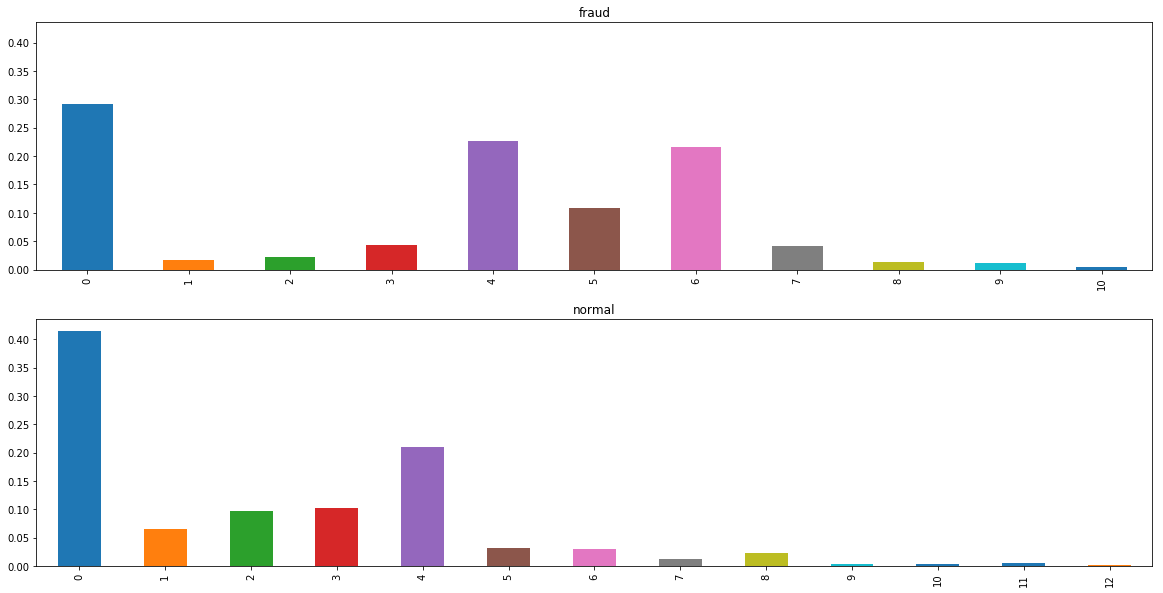

In [17]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'メール数字')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['メール数字'],normal_df['メール数字']))

In [18]:
def splitmail(row):
    if row['Billing Emailアドレス']:
        mailtuple = row['Billing Emailアドレス'].split('@')
        if len(mailtuple) == 2:
            return mailtuple
        else:
            return ["",""]
    else :
        return ["",""]

In [19]:
fraud_df['メールユーザーネーム'] = fraud_df.apply(lambda x: splitmail(x)[0],axis=1)
fraud_df['メールドメイン'] = fraud_df.apply(lambda x: splitmail(x)[1],axis=1)
normal_df['メールユーザーネーム'] = normal_df.apply(lambda x: splitmail(x)[0],axis=1)
normal_df['メールドメイン'] = normal_df.apply(lambda x: splitmail(x)[1],axis=1)

In [20]:
fraud_df['ユーザ―長さ'] = fraud_df['メールユーザーネーム'].str.len()
fraud_df['ドメイン長さ'] = fraud_df['メールドメイン'].str.len()
normal_df['ユーザ―長さ'] = normal_df['メールユーザーネーム'].str.len()
normal_df['ドメイン長さ'] = normal_df['メールドメイン'].str.len()

ユーザ―長さ  ユーザ―長さ      不正割合      正常割合        OR       p value
16     202   21297  0.113867  0.035894  3.451443  1.327415e-45
22      26    2996  0.014656  0.005049  2.930807  2.636569e-06
23      20    2447  0.011274  0.004124  2.753387  7.947959e-05
24      12    1980  0.006764  0.003337  2.034014  2.098041e-02

ユーザ―長さ  ユーザ―長さ      不正割合      正常割合        OR       p value
8      74   82216  0.041714  0.138567  0.270610  1.409171e-41
7      35   41748  0.019729  0.070362  0.265915  3.945145e-22
6       7   28892  0.003946  0.048695  0.077393  7.785284e-29
5       4   13742  0.002255  0.023161  0.095314  2.938346e-13

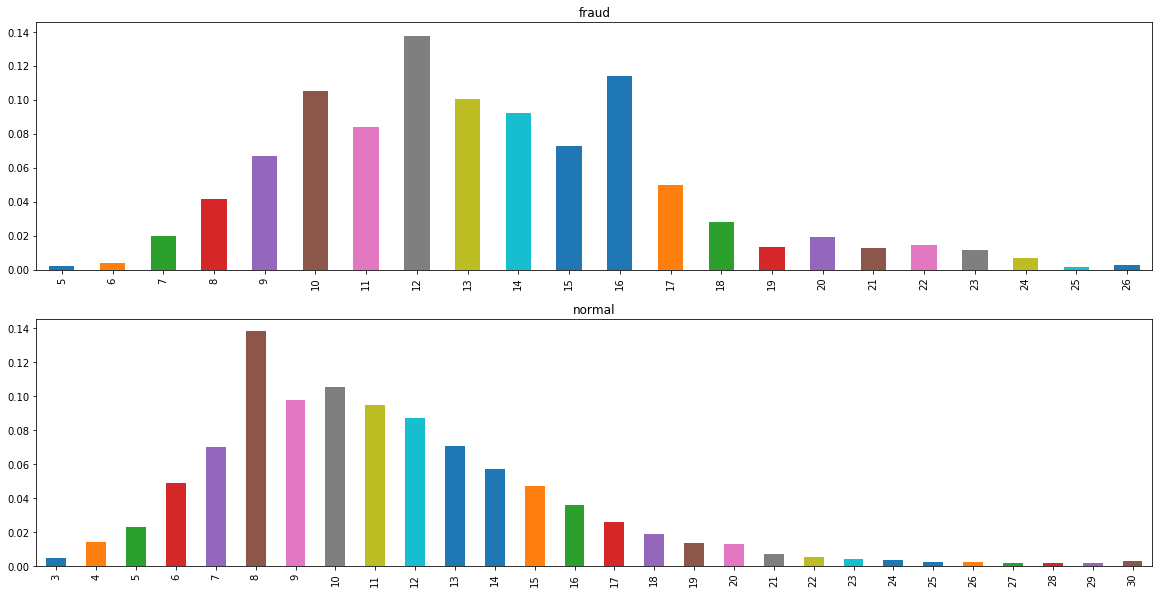

In [21]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'ユーザ―長さ')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['ユーザ―長さ'],normal_df['ユーザ―長さ']))

ドメイン長さ  ドメイン長さ      不正割合      正常割合        OR        p value
9    1054  149005  0.594138  0.251134  4.365229  3.166852e-204
7     113    6729  0.063698  0.011341  5.930623   3.241718e-47

ドメイン長さ  ドメイン長さ      不正割合      正常割合        OR       p value
12      59   65493  0.033258  0.110382  0.277263  1.108317e-32
14       5   27700  0.002818  0.046686  0.057716  1.559827e-29
10       5   25693  0.002818  0.043303  0.062445  4.549268e-27

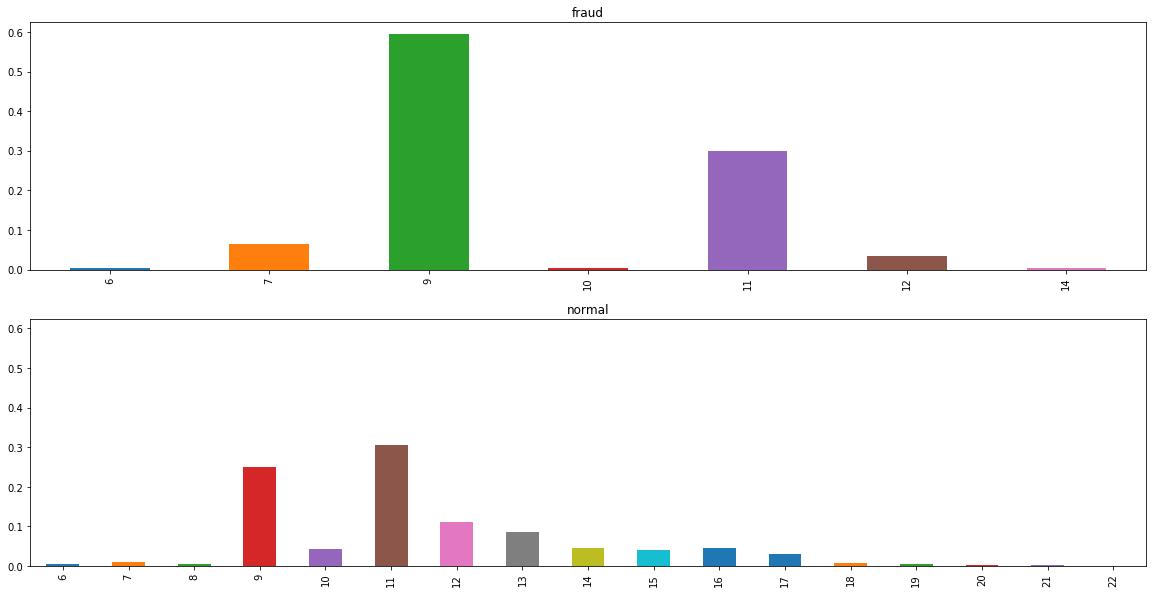

In [22]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'ドメイン長さ')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['ドメイン長さ'],normal_df['ドメイン長さ']))

In [23]:
fraud_domain = fraud_df.groupby('メールドメイン')['トランザクションID'].count()/len(fraud_df.index)
normal_domain = normal_df.groupby('メールドメイン')['トランザクションID'].count()/len(normal_df.index)

トランザクションID  トランザクションID      不正割合      正常割合          OR   p value
59            1           3  0.000564  0.000005  111.548411  0.011871
113           1           3  0.000564  0.000005  111.548411  0.011871

トランザクションID  トランザクションID      不正割合      正常割合        OR       p value
2           5        4578  0.002818  0.007716  0.363495  1.352397e-02
1           5       10070  0.002818  0.016972  0.163710  3.238076e-08

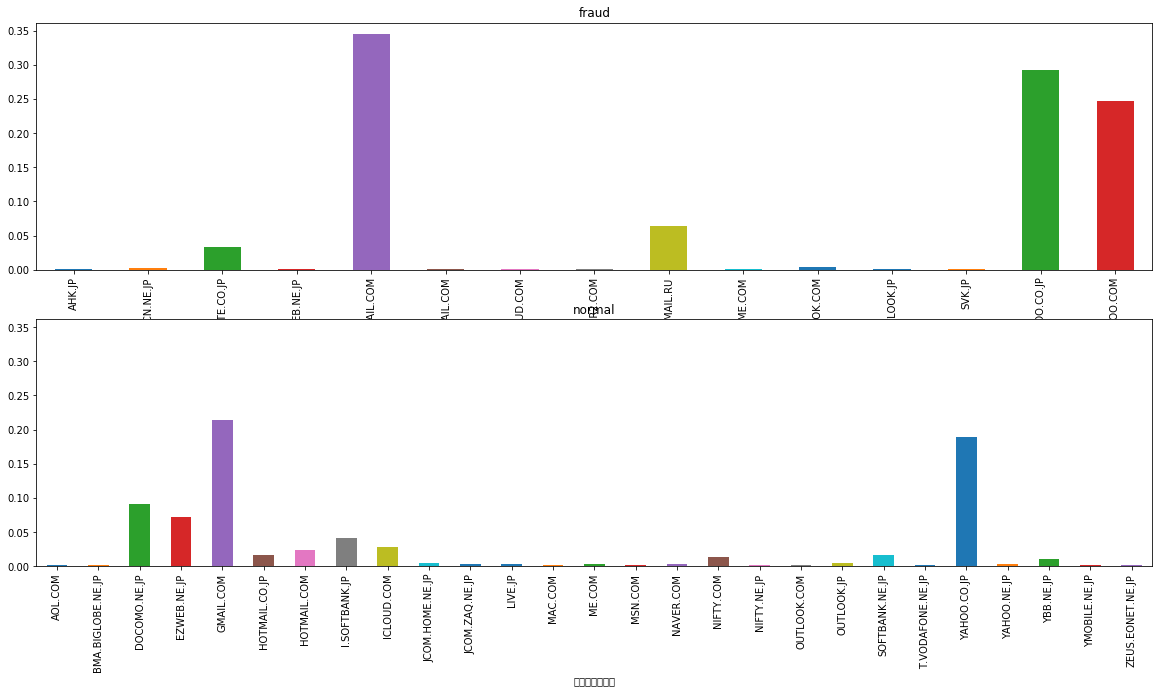

In [24]:
plotDistr(fraud_domain,normal_domain)
displayOR(getmerge(fraud_df.groupby('メールドメイン')['トランザクションID'].count(),normal_df.groupby('メールドメイン')['トランザクションID'].count()))

In [25]:
def hasAddressRomaji(row):
    if re.search("([a-zA-Z]{1,4}\s)+",row['Billing 住所']):
        return True
    else :
        return False

In [26]:
def hasAddressNumber(row):
    if re.search("(\d{1,4})(-)(\d{1,3})(-)(\d{1,3})",row['Billing 住所']):
        return True
    else:
        return False

In [27]:
fraud_df['住所ローマ字'] = fraud_df.apply(lambda x: hasAddressRomaji(x),axis=1)
normal_df['住所ローマ字'] = normal_df.apply(lambda x: hasAddressRomaji(x),axis=1)

住所ローマ字  住所ローマ字      不正割合      正常割合        OR       p value
True      98    5686  0.055242  0.009583  6.043086  5.609027e-42

住所ローマ字  住所ローマ字      不正割合      正常割合        OR       p value
False    1676  587643  0.944758  0.990417  0.165478  5.609027e-42

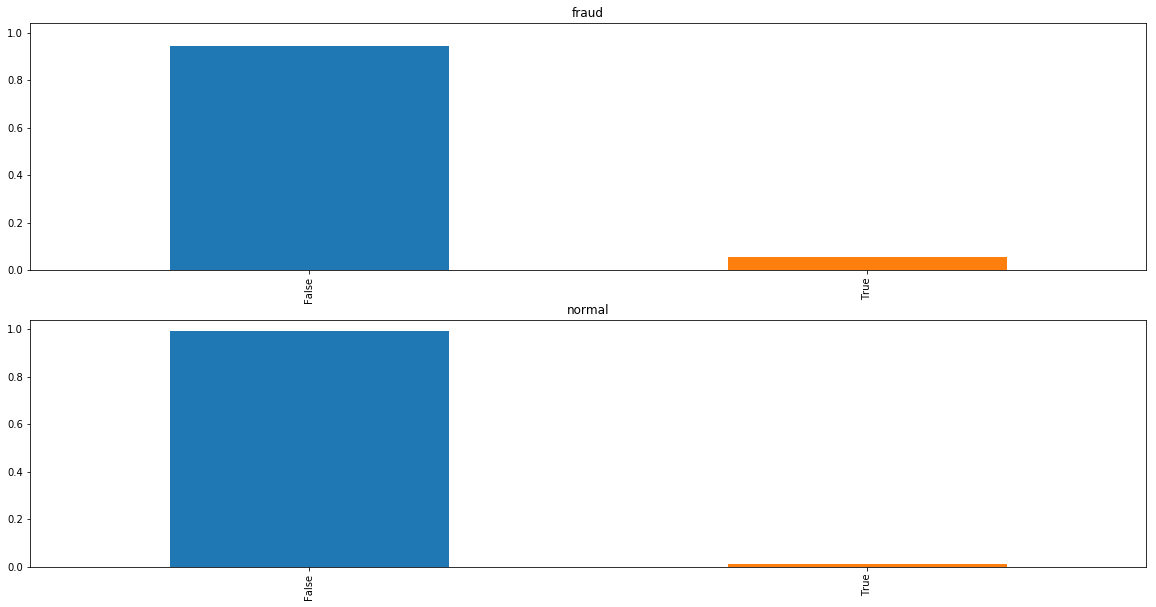

In [28]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'住所ローマ字')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['住所ローマ字'],normal_df['住所ローマ字']))

In [29]:
fraud_df['住所数字'] = fraud_df.apply(lambda x: hasAddressNumber(x),axis=1)
normal_df['住所数字'] = normal_df.apply(lambda x: hasAddressNumber(x),axis=1)

Empty DataFrame
Columns: [住所数字, 住所数字, 不正割合, 正常割合, OR, p value]
Index: []

Empty DataFrame
Columns: [住所数字, 住所数字, 不正割合, 正常割合, OR, p value]
Index: []

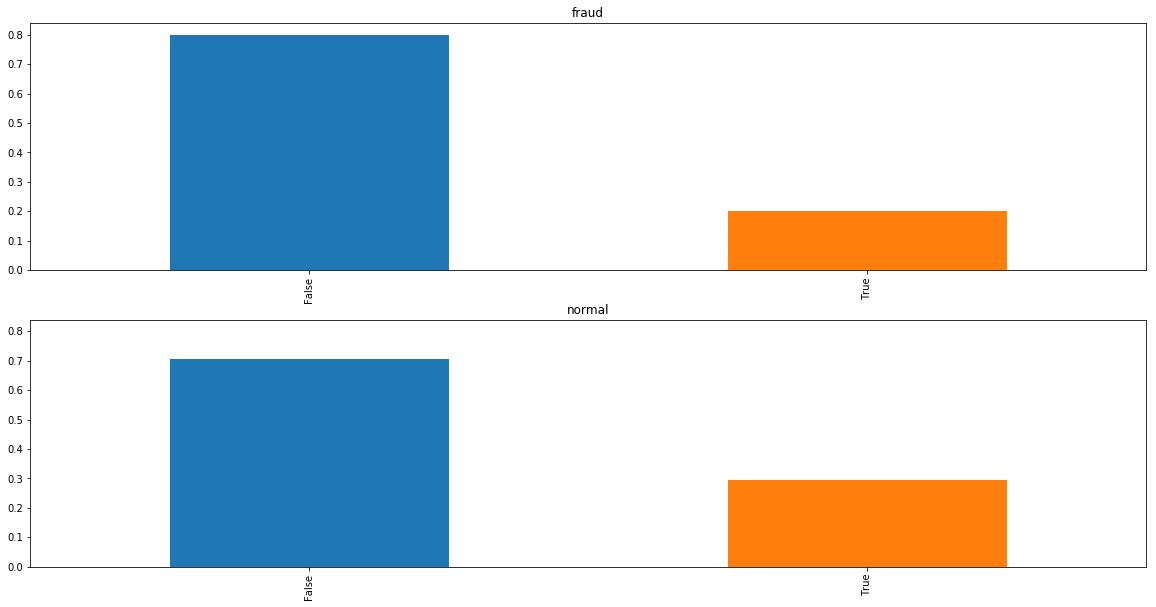

In [30]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'住所数字')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['住所数字'],normal_df['住所数字']))

In [31]:
fraud_df['トランザクション 日時'] = pd.to_datetime(fraud_df['トランザクション 日時'])
normal_df['トランザクション 日時'] = pd.to_datetime(normal_df['トランザクション 日時'])

fraud_df['チェックイン日時'] = pd.to_datetime(fraud_df['チェックイン日時'])
normal_df['チェックイン日時'] = pd.to_datetime(normal_df['チェックイン日時'])

fraud_df['チェックアウト日時'] = pd.to_datetime(fraud_df['チェックアウト日時'])
normal_df['チェックアウト日時'] = pd.to_datetime(normal_df['チェックアウト日時'])

In [32]:
fraud_df['トランザクション曜日'] = fraud_df['トランザクション 日時'].dt.dayofweek
normal_df['トランザクション曜日'] = normal_df['トランザクション 日時'].dt.dayofweek
fraud_df['トランザクション時間'] = fraud_df['トランザクション 日時'].dt.hour
normal_df['トランザクション時間'] = normal_df['トランザクション 日時'].dt.hour

fraud_df['チェックイン曜日'] = fraud_df['チェックイン日時'].dt.dayofweek
normal_df['チェックイン曜日'] = normal_df['チェックイン日時'].dt.dayofweek
fraud_df['チェックイン時間'] = fraud_df['チェックイン日時'].dt.hour
normal_df['チェックイン時間'] = normal_df['チェックイン日時'].dt.hour

fraud_df['チェックアウト曜日'] = fraud_df['チェックアウト日時'].dt.dayofweek
normal_df['チェックアウト曜日'] = normal_df['チェックアウト日時'].dt.dayofweek
fraud_df['チェックアウト時間'] = fraud_df['チェックアウト日時'].dt.hour
normal_df['チェックアウト時間'] = normal_df['チェックアウト日時'].dt.hour

Empty DataFrame
Columns: [トランザクション曜日, トランザクション曜日, 不正割合, 正常割合, OR, p value]
Index: []

Empty DataFrame
Columns: [トランザクション曜日, トランザクション曜日, 不正割合, 正常割合, OR, p value]
Index: []

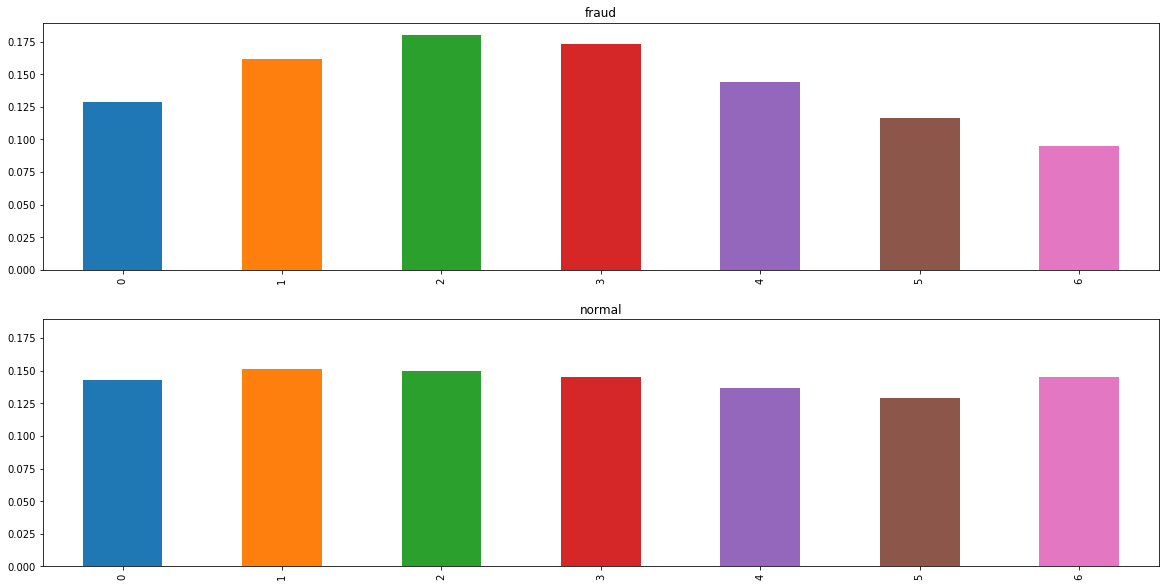

In [33]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'トランザクション曜日')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['トランザクション曜日'],normal_df['トランザクション曜日']))

トランザクション時間  トランザクション時間      不正割合      正常割合        OR       p value
23         316       41593  0.178129  0.070101  2.875018  1.035036e-51
22         288       48427  0.162345  0.081619  2.180743  1.883551e-28
0          254       25658  0.143179  0.043244  3.697124  4.013776e-61
1           77       13117  0.043405  0.022107  2.007063  6.475463e-08

トランザクション時間  トランザクション時間      不正割合      正常割合        OR       p value
10          26       27547  0.014656  0.046428  0.305497  3.681328e-13
11          21       29712  0.011838  0.050077  0.227243  3.295768e-18
9           11       22962  0.006201  0.038700  0.154983  6.454052e-18
8            7       16181  0.003946  0.027272  0.141300  1.631425e-13
7            4       10432  0.002255  0.017582  0.126273  1.944992e-09
3            3        3236  0.001691  0.005454  0.308898  2.309216e-02
6            2        5837  0.001127  0.009838  0.113600  9.145945e-06
5            1        2920  0.000564  0.004921  0.114041  3.179375e-03

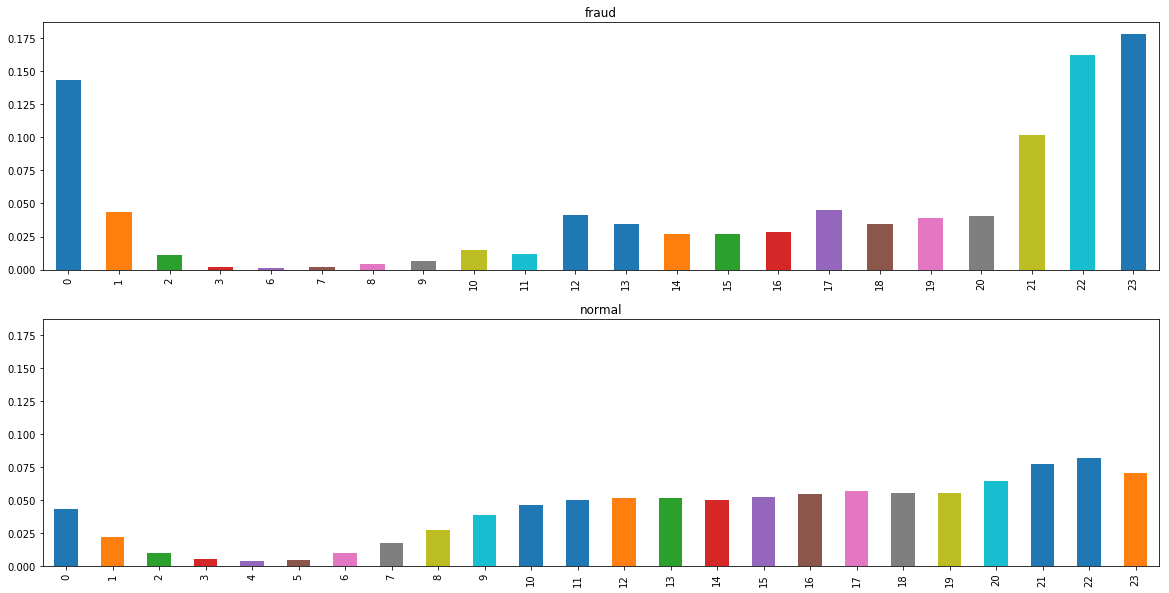

In [34]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'トランザクション時間')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['トランザクション時間'],normal_df['トランザクション時間']))

Empty DataFrame
Columns: [チェックイン曜日, チェックイン曜日, 不正割合, 正常割合, OR, p value]
Index: []

Empty DataFrame
Columns: [チェックイン曜日, チェックイン曜日, 不正割合, 正常割合, OR, p value]
Index: []

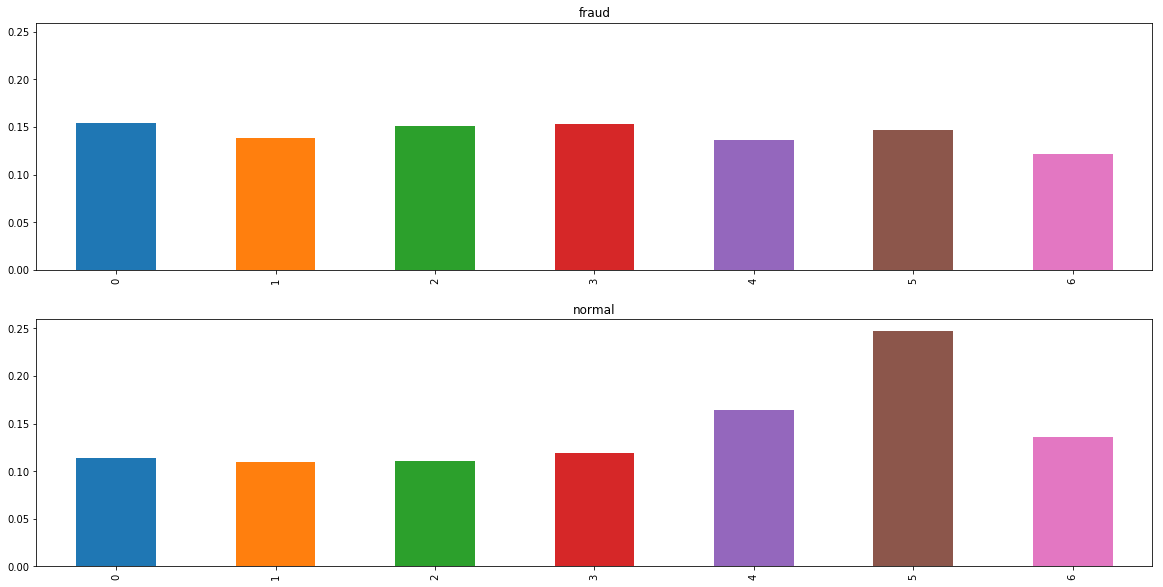

In [35]:
fraud_bnl, normal_bnl = colFreq(fraud_df,normal_df,'チェックイン曜日')
plotDistr(fraud_bnl,normal_bnl)
displayOR(getmerge(fraud_df['チェックイン曜日'],normal_df['チェックイン曜日']))

チェックイン時間  チェックイン時間      不正割合      正常割合         OR   p value
20       909     48056  0.512401  0.080994  11.923785  0.000000
13         9      1300  0.005073  0.002191   2.322188  0.018305

チェックイン時間  チェックイン時間      不正割合      正常割合        OR       p value
15        70    102771  0.039459  0.173211  0.196087  1.368147e-67
21        43     43438  0.024239  0.073211  0.314469  1.983272e-19
17        43     74082  0.024239  0.124858  0.174114  1.051364e-52
22        14     46312  0.007892  0.078055  0.093956  1.863160e-43
23         6     37974  0.003382  0.064002  0.049631  1.167615e-41
0          6     23012  0.003382  0.038785  0.084107  1.824171e-22
1          2      3641  0.001127  0.006137  0.182797  3.152971e-03

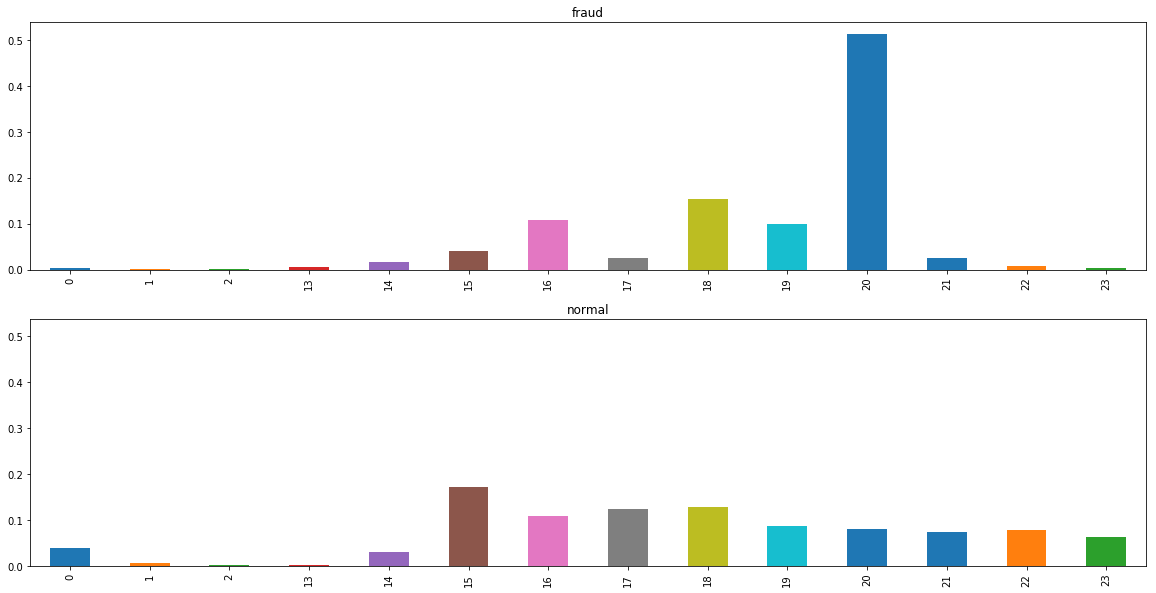

In [36]:
fraud_cowd, normal_cowd = colFreq(fraud_df,normal_df,'チェックイン時間')
plotDistr(fraud_cowd,normal_cowd)
displayOR(getmerge(fraud_df['チェックイン時間'],normal_df['チェックイン時間']))

Empty DataFrame
Columns: [チェックアウト曜日, チェックアウト曜日, 不正割合, 正常割合, OR, p value]
Index: []

チェックアウト曜日  チェックアウト曜日      不正割合      正常割合       OR       p value
6        240     150908  0.135287  0.254341  0.45868  1.495876e-34

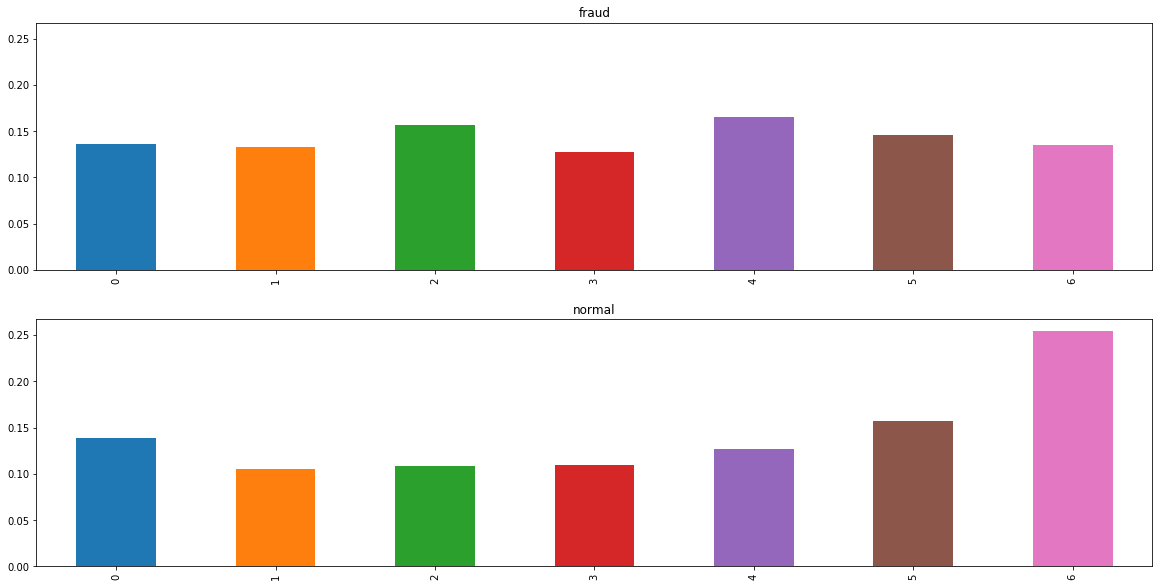

In [37]:
fraud_cowd, normal_cowd = colFreq(fraud_df,normal_df,'チェックアウト曜日')
plotDistr(fraud_cowd,normal_cowd)
displayOR(getmerge(fraud_df['チェックアウト曜日'],normal_df['チェックアウト曜日']))

In [38]:
fraud_cowd, normal_cowd = colFreq(fraud_df,normal_df,'チェックアウト時間')
plotDistr(fraud_cowd,normal_cowd)
displayOR(getmerge(fraud_df['チェックアウト時間'],normal_df['チェックアウト時間']))

チェックアウト時間  チェックアウト時間      不正割合      正常割合          OR        p value
12        465      46426  0.262120  0.078247    4.184681  2.171676e-119
21          2          5  0.001127  0.000008  133.933183   1.846653e-04

チェックアウト時間  チェックアウト時間      不正割合      正常割合        OR       p value
10        485     307244  0.273393  0.517831  0.350349  9.524333e-97

In [39]:
fraud_df['dtime'] = fraud_df['チェックアウト日時'] - fraud_df['チェックイン日時']
normal_df['dtime'] = normal_df['チェックアウト日時'] - normal_df['チェックイン日時']

In [40]:
fraud_dtime, normal_dtime = colFreq(fraud_df,normal_df,'dtime')
plotDistr(fraud_dtime,normal_dtime)
displayOR_OLD(getmerge_OLD(fraud_dtime[fraud_dtime>0.01],normal_dtime[normal_dtime>0.01]))

dtime  dtime            OR
2 days 16:00:00  0.029876    NaN  3.079605e+61
1 days 14:00:00  0.022548    NaN  2.306805e+61
3 days 15:00:00  0.020293    NaN  2.071346e+61
2 days 14:00:00  0.016911    NaN  1.720183e+61
3 days 16:00:00  0.015784    NaN  1.603666e+61

dtime     dtime        OR
19:00:00  0.050169  0.108511  0.433941
14:00:00  0.029312  0.062143  0.455741
20:00:00  0.019166  0.068144  0.267208
21:00:00  0.010147  0.031005  0.320363

In [41]:
fraud_df.describe()

トランザクション 合計 金額  Billing POST_CODE緯度  Billing POST_CODE経度  トランザクションスコア  \
count     1774.000000          1774.000000          1774.000000  1774.000000   
mean     94092.414318            33.726924           129.483995  2884.886697   
std      91500.464230             8.604071            31.821891  1056.966580   
min       3800.000000             0.000000             0.000000  -150.000000   
25%      47255.000000            34.653000           134.997000  2210.000000   
50%      64900.000000            35.299000           137.157000  2930.000000   
75%      92760.000000            35.897000           139.714000  3650.000000   
max     753660.000000            45.404000           144.380000  5000.000000   

       InAuth デバイス位置緯度  InAuth デバイス位置経度   クレンズ済課金電話番号  クレンズ済課金電話番号81  \
count      1774.000000      1774.000000  1.774000e+03   1.774000e+03   
mean         34.126227       134.766209  9.678798e+09   1.101909e+12   
std           9.207500        19.268459  1.234254e+10   2.372348e+12   
min         -33.867000       -79.955000  2.928662e+07   8.129287e+09   
25%          34.692000       135.508000  8.013314e+09   8.180133e+11   
50%          35.463000       139.538000  8.054604e+09   8.180546e+11   
75%          35.739000       139.739000  9.022940e+09   8.190229e+11   
max          50.111000       151.207000  1.926333e+11   8.119263e+13   

                宿泊ID        メール長さ        メール数字       ユーザ―長さ       ドメイン長さ  \
count    1774.000000  1774.000000  1774.000000  1774.000000  1774.000000   
mean   340163.975761    23.918264     3.509583    13.347802     9.570462   
std     28122.375387     4.049548     2.614263     3.666929     1.241484   
min    300063.000000    12.000000     0.000000     5.000000     6.000000   
25%    316987.000000    21.000000     0.000000    11.000000     9.000000   
50%    331817.000000    24.000000     4.000000    13.000000     9.000000   
75%    361794.000000    27.000000     6.000000    16.000000    11.000000   
max    399872.000000    38.000000    13.000000    26.000000    14.000000   

        トランザクション曜日   トランザクション時間     チェックイン曜日     チェックイン時間    チェックアウト曜日  \
count  1774.000000  1774.000000  1774.000000  1774.000000  1774.000000   
mean      2.773957    15.393461     2.903608    18.689402     3.032131   
std       1.844850     8.350992     1.973387     2.271213     1.970906   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000    12.000000     1.000000    18.000000     1.000000   
50%       3.000000    19.000000     3.000000    20.000000     3.000000   
75%       4.000000    22.000000     5.000000    20.000000     5.000000   
max       6.000000    23.000000     6.000000    23.000000     6.000000   

         チェックアウト時間                   dtime  
count  1774.000000                    1774  
mean     11.000000  1 days 10:18:36.629086  
std       0.805368  1 days 02:47:21.892763  
min      10.000000         0 days 08:00:00  
25%      10.000000         0 days 16:00:00  
50%      11.000000         0 days 19:00:00  
75%      12.000000         1 days 16:00:00  
max      21.000000         8 days 18:00:00

In [42]:
normal_df.describe()

RESOLUTION1_NAME  トランザクション 合計 金額  Billing POST_CODE緯度  \
count               0.0   593329.000000        593329.000000   
mean                NaN    27057.927494            34.937221   
std                 NaN    34398.131234             5.735380   
min                 NaN        1.000000             0.000000   
25%                 NaN     7990.000000            34.707000   
50%                 NaN    15076.000000            35.512000   
75%                 NaN    33480.000000            35.836000   
max                 NaN   991440.000000            45.522000   

       Billing POST_CODE経度    トランザクションスコア  InAuth デバイス位置緯度  InAuth デバイス位置経度  \
count        593329.000000  593329.000000    593329.000000    593329.000000   
mean            134.422588     709.044539        26.808285       103.637640   
std              20.410987    1196.668671        15.391955        60.136753   
min               0.000000  -10020.000000       -46.411000      -159.418000   
25%             135.475000     -30.000000        25.042000       114.110000   
50%             139.027000     380.000000        35.423000       137.214000   
75%             139.734000    1110.000000        35.696000       139.739000   
max             145.753000   27580.000000        64.142000       176.913000   

        クレンズ済課金電話番号  クレンズ済課金電話番号81           宿泊ID           ...            \
count  5.933290e+05   5.933290e+05  593329.000000           ...             
mean   5.927374e+11   5.739379e+13  342508.139560           ...             
std    6.942457e+13   6.563916e+15   28134.912029           ...             
min    0.000000e+00   8.109752e+08  300000.000000           ...             
25%    8.017989e+09   8.180180e+11  318988.000000           ...             
50%    9.018889e+09   8.190189e+11  336041.000000           ...             
75%    9.059140e+09   8.190592e+11  365187.000000           ...             
max    9.098901e+15   8.190989e+17  399972.000000           ...             

               メール数字         ユーザ―長さ         ドメイン長さ     トランザクション曜日  \
count  593329.000000  593329.000000  593329.000000  593329.000000   
mean        2.158807      11.194671      11.508318       2.948931   
std         2.354225       4.290656       2.513766       1.998583   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       8.000000       9.000000       1.000000   
50%         2.000000      10.000000      11.000000       3.000000   
75%         4.000000      13.000000      13.000000       5.000000   
max        26.000000      47.000000      38.000000       6.000000   

          トランザクション時間       チェックイン曜日       チェックイン時間      チェックアウト曜日  \
count  593329.000000  593329.000000  593329.000000  593329.000000   
mean       14.838265       3.397323      17.240244       3.471529   
std         6.273109       1.946581       4.612609       2.144570   
min         0.000000       0.000000       0.000000       0.000000   
25%        11.000000       2.000000      15.000000       2.000000   
50%        16.000000       4.000000      18.000000       4.000000   
75%        20.000000       5.000000      20.000000       6.000000   
max        23.000000       6.000000      23.000000       6.000000   

           チェックアウト時間                   dtime  
count  593329.000000                  593329  
mean       10.558323  0 days 22:31:52.160032  
std         0.657344  0 days 18:04:49.200522  
min         8.000000         0 days 05:00:00  
25%        10.000000         0 days 15:00:00  
50%        10.000000         0 days 17:00:00  
75%        11.000000         0 days 20:00:00  
max        22.000000         9 days 04:00:00  

[8 rows x 21 columns]